## Part B4 - Price Modeling by Sampling

### 4.1 - Import Libraries & Loading Data

In [ ]:
# Cell 1: Import libraries and configure environment

# --- Core Libraries ---
import pandas as pd
import numpy as np
import random
import warnings
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Scikit-learn: Data Preparation & Modeling ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Progress Bar ---
from tqdm import tqdm
tqdm.pandas()

# --- Warnings ---
warnings.simplefilter("ignore", ConvergenceWarning)

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from tqdm import tqdm



### 4.2 - Data Preproseccing

In this step, we start by loading the raw dataset from the provided CSV file. We immediately clean it by removing any rows with missing `Discount Price`, since this is our prediction target.

Next, we narrow the data down to the top 40 hotels with the most entries — this aligns with the project instructions to focus on the most data-rich hotels. We also limit the data to only include check-in dates within 30 days of the snapshot, as required.

After filtering, we group the data by `Hotel Name`, `Snapshot Date`, and `Discount Code`, and keep only groups with at least 5 rows. These “valid groups” ensure we have enough samples to train a meaningful model per group.

This gives us two main outputs:
- `df`: the cleaned and filtered dataset.
- `grouped`: the unique group combinations we'll use for modeling in later stages.


In [48]:
def load_and_filter_data(csv_path):

    # Step 1: Load raw data
    df = pd.read_csv(csv_path)
    print("Step 1 - Initial rows:", df.shape[0])

    # Step 2: Remove rows with missing Discount Price
    df = df[df['Discount Price'].notna()]
    print("Step 2 - After removing missing Discount Price:", df.shape[0])

    # Step 3: Keep top 40 hotels with the most data
    top_40_hotels = df['Hotel Name'].value_counts().head(40).index
    df = df[df['Hotel Name'].isin(top_40_hotels)]
    print("Step 3 - After keeping only top 40 hotels:", df.shape[0])

    # Step 4: Filter to only include rows within 30 days
    df = df[df['DayDiff'] <= 30]
    print("Step 4 - After filtering DayDiff ≤ 30:", df.shape[0])

    # Step 5: Group by hotel, snapshot date and discount code
    grouped = df.groupby(['Hotel Name', 'Snapshot Date', 'Discount Code']).size().reset_index(name='Count')
    print("Step 5 - Total groups after grouping:", grouped.shape[0])

    # Step 6: Keep only groups with at least 5 samples
    grouped = grouped[grouped['Count'] >= 5].copy()
    print("Step 6 - Groups with Count ≥ 5:", grouped.shape[0])

    # Step 7: Sort by Count descending and reset index
    grouped = grouped.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # Step 8: Preview top 10 groups
    print("\nTop 10 groups with the highest number of samples:")
    display(grouped.head(10))

    return df, grouped


# Load and process data
df, grouped = load_and_filter_data("Data/Hotels_data_Changed.csv")


Step 1 - Initial rows: 187848
Step 2 - After removing missing Discount Price: 187848
Step 3 - After keeping only top 40 hotels: 101564
Step 4 - After filtering DayDiff ≤ 30: 88700
Step 5 - Total groups after grouping: 19224
Step 6 - Groups with Count ≥ 5: 7503

Top 10 groups with the highest number of samples:


,Hotel Name,Snapshot Date,Discount Code,Count
0,Park Hyatt New York,2015-07-22,3,44
1,Park Hyatt New York,2015-07-22,2,43
2,The New York EDITION,2015-07-27,2,30
3,The New York EDITION,2015-07-29,3,30
4,The New York EDITION,2015-07-29,2,30
5,The New York EDITION,2015-07-27,3,30
6,Newark Liberty International Airport Marriott,2015-07-23,3,30
7,Park Hyatt New York,2015-07-22,1,30
8,Newark Liberty International Airport Marriott,2015-07-22,3,30
9,The New York EDITION,2015-07-28,3,29


### 4.3 - Feature Engineering, Train/Test Split & Normalization

In this step, we prepared the data for modeling by applying several key preprocessing stages:

- **Feature Engineering**:
  - Converted `Checkin Date` into an ordinal number to represent time numerically.
  - Mapped `WeekDay` strings to integers (0 for Monday through 6 for Sunday).
  - Dropped unused columns like `Snapshot ID`, `Checkin Date`, and `WeekDay`.

- **Valid Group Filtering**:
  - Kept only rows that belong to groups with at least 5 samples, based on the combinations of `Hotel Name`, `Snapshot Date`, and `Discount Code`.

- **Train/Test Split**:
  - Performed an 80/20 split using `train_test_split`, stratified by `Hotel Name` to preserve group representation across sets.

- **Normalization**:
  - Applied `StandardScaler` on selected numerical features.
  - The scaler was fitted on the training set and then used to transform both train and test sets, ensuring consistent scaling.

This process leaves us with two clean DataFrames: `train_df` and `test_df`, both ready for baseline modeling and GPR sampling.


In [ ]:
# Cell 3: Feature Engineering, Split & Normalization

def feature_engineering(df):
    df = df.copy()

    # Convert to datetime & create ordinal version of Checkin Date
    df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
    df['Checkin_Ordinal'] = df['Checkin Date'].map(pd.Timestamp.toordinal)

    # Weekday mapping
    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['Weekday_Num'] = df['WeekDay'].map(weekday_map)

    # Drop unused columns
    drop_cols = ['Snapshot ID', 'Checkin Date', 'WeekDay']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    return df

def normalize(df, features_to_scale, scaler=None):
    df_scaled = df.copy()
    if scaler is None:
        scaler = StandardScaler()
        df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    else:
        df_scaled[features_to_scale] = scaler.transform(df_scaled[features_to_scale])
    return df_scaled, scaler

# Step 1: Feature Engineering 
df_engineered = feature_engineering(df)

# Step 2: Filter to valid groups (at least 5 samples per group) 
valid_groups = grouped[['Hotel Name', 'Snapshot Date', 'Discount Code']]
merged_df = pd.merge(df_engineered, valid_groups, on=['Hotel Name', 'Snapshot Date', 'Discount Code'], how='inner')

# Step 3: Split to train/test (raw, before normalization) 
train_df_raw, test_df_raw = train_test_split(
    merged_df,
    test_size=0.2,
    random_state=42,
    stratify=merged_df['Hotel Name']
)

# Step 4: Normalization 
features_to_scale = [
    "Checkin_Ordinal", "Original Price", "Discount Price",
    "Available Rooms", "DayDiff", "DiscountDiff", "DiscountPerc"
]

train_df, fitted_scaler = normalize(train_df_raw, features_to_scale)
test_df, _ = normalize(test_df_raw, features_to_scale, scaler=fitted_scaler)

print("Feature engineering, splitting & normalization completed.")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape    : {test_df.shape}")

Feature engineering, splitting & normalization completed.
Training set shape: (48516, 13)
Test set shape    : (12129, 13)


### 4.4 -  Base Model with Train/Test Evaluation

In this step, we implemented a simple baseline model using `LinearRegression`, with the goal of evaluating performance on both train and test sets for each group.

The logic was applied **per group**, where each group is defined by a unique combination of `Hotel Name`, `Snapshot Date`, and `Discount Code`.

- **Group Filtering**:
  - We only evaluated groups that appear in both the train and test sets.
  - Groups with fewer than `sample_size` (default = 10) training samples or fewer than 3 test samples were skipped.

- **Sampling Strategy**:
  - For each group, we randomly sampled `sample_size` points from the train set to simulate a low-data scenario.
  - The model was trained only on the sampled data, but evaluated on the full group (both train and test).

- **Feature Selection**:
  - Used key numerical features such as `DayDiff`, `Available Rooms`, and price-related fields (`Original Price`, `DiscountPerc`, etc.).

- **Performance Evaluation**:
  - Calculated standard regression metrics (R², MAE, RMSE) separately for train and test data.
  - The results were collected into a DataFrame (`base_model_results`) for later analysis.

This approach allows us to simulate a minimal-sample modeling scenario, while still measuring generalization to unseen dates via the test set.


In [ ]:
# Cell 4: Base Model With Evaluation (Train + Test)

def base_model_with_evaluation(grouped_df, train_df, test_df, sample_size=10):
    results = []

    for _, row in tqdm(grouped_df.iterrows(), total=grouped_df.shape[0], desc="Training Base Model (With Evaluation)"):
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Train group
        train_group = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code)
        ].copy()

        # Test group
        test_group = test_df[
            (test_df['Hotel Name'] == hotel) &
            (pd.to_datetime(test_df['Snapshot Date']) == snapshot_date) &
            (test_df['Discount Code'] == discount_code)
        ].copy()

        if train_group.empty or test_group.empty:
            continue

        if train_group.shape[0] < sample_size or test_group.shape[0] < 3:
            continue

        feature_candidates = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms',
            'DayDiff', 'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_candidates if f in train_group.columns]

        # Sampled data for fitting
        sample = train_group.sample(n=sample_size, random_state=42)
        X_sample = sample[selected_features]
        y_sample = sample['Discount Price']

        # Full sets for evaluation
        X_train = train_group[selected_features]
        y_train = train_group['Discount Price']
        X_test = test_group[selected_features]
        y_test = test_group['Discount Price']

        model = LinearRegression()
        model.fit(X_sample, y_sample)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        results.append({
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Train Size': len(X_train),
            'Test Size': len(X_test),
            'Num Samples Used': sample_size,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        })

    return pd.DataFrame(results)


In [ ]:
# Cell 5: Run base model with evaluation on grouped data

# Run base model evaluation using train/test sets
base_model_results = base_model_with_evaluation(grouped, train_df, test_df, sample_size=10)
print("Base model evaluation completed.")

Training Base Model (With Evaluation): 100%|██████████| 7503/7503 [02:56<00:00, 42.54it/s]

Base model evaluation completed.


### 4.5 - Analyze - Base Model Evaluation & Feature Enrichment

After training the base model across all valid groups, this cell focuses on analyzing its performance and enriching the results for further interpretation.

- **Performance Summary**:
  - Computed average metrics (R² and MAE) separately for train and test sets.
  - Printed the number of total trained models and a breakdown into "Good" models (`Test R² >= 0`) and "Bad" models (`Test R² < 0`).

- **Statistical Comparison**:
  - Descriptive statistics (`mean`, `std`) were calculated for both good and bad models.
  - A side-by-side table was created to highlight differences in performance and dataset sizes.

- **Visualizations**:
  - A scatter plot showing `Train R²` vs `Test R²` was generated to explore generalization.
  - MAE distributions were compared using overlaid histograms for train and test sets.

- **Result Enrichment**:
  - Merged each group (good and bad) back with the original engineered data to allow further exploration.
  - A new column `Performance` was added to label each entry as either 'Good' or 'Bad'.

This analysis helped us understand which types of groups yielded poor test performance, and prepares the data for feature-level comparison in later stages.


In [131]:
# Cell 6: Analyze Base Model Results & Enrich with Features

if base_model_results is not None and not base_model_results.empty:
    
    avg_train_r2 = base_model_results['Train R²'].mean()
    avg_test_r2 = base_model_results['Test R²'].mean()
    avg_train_mae = base_model_results['Train MAE'].mean()
    avg_test_mae = base_model_results['Test MAE'].mean()

    print(f"📊 Base Model Performance Summary:")
    print(f"📦 Total models trained: {len(base_model_results)}")
    print(f"🔹 Average Train R²: {avg_train_r2:.4f}")
    print(f"🔹 Average Test  R²: {avg_test_r2:.4f}")
    print(f"🔹 Average Train MAE: {avg_train_mae:.2f}")
    print(f"🔹 Average Test  MAE: {avg_test_mae:.2f}")

    good_models = base_model_results[base_model_results['Test R²'] >= 0].copy()
    bad_models = base_model_results[base_model_results['Test R²'] < 0].copy()

    print(f"\n✅ Good models: {len(good_models)}")
    print(f"❌ Bad models : {len(bad_models)}")

    numeric_cols = ['Train R²', 'Test R²', 'Train MAE', 'Test MAE', 'Train Size', 'Test Size']
    good_stats = good_models[numeric_cols].describe().T
    bad_stats = bad_models[numeric_cols].describe().T

    comparison = pd.concat([good_stats[['mean', 'std']], bad_stats[['mean', 'std']]], axis=1)
    comparison.columns = ['Good Mean', 'Good Std', 'Bad Mean', 'Bad Std']

    print("\n📈 Statistical Comparison Between Good and Bad Models:")
    display(comparison)

    # --- Visualization: R² train vs test ---
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=base_model_results, x='Train R²', y='Test R²', alpha=0.6)
    plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal: y = x')
    plt.title('Train vs Test R² (Base Model)')
    plt.xlabel('Train R²')
    plt.ylabel('Test R²')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Visualization: MAE distributions ---
    plt.figure(figsize=(10, 5))

    # Check if the data is valid and not too large
    try:
        # Sample a subset of the data if it's too large
        if len(base_model_results) > 10000:
            sample_data = base_model_results.sample(n=10000, random_state=42)  # Sample 10,000 rows
        else:
            sample_data = base_model_results

        # Plot histograms without KDE
        sns.histplot(sample_data['Train MAE'], color='blue', label='Train MAE', kde=False, stat='density')
        sns.histplot(sample_data['Test MAE'], color='orange', label='Test MAE', kde=False, stat='density')

        plt.title('MAE Distribution – Train vs Test')
        plt.xlabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # --- Enrich with Features Section ---
        
        def enrich_results(subset, label):
            # Ensure Snapshot Date is in datetime format on both sides
            subset = subset.copy()
            subset['Snapshot Date'] = pd.to_datetime(subset['Snapshot Date'])
            df_engineered_copy = df_engineered.copy()
            df_engineered_copy['Snapshot Date'] = pd.to_datetime(df_engineered_copy['Snapshot Date'])

            merged = pd.merge(
                subset[['Hotel Name', 'Snapshot Date', 'Discount Code']],
                df_engineered_copy,
                on=['Hotel Name', 'Snapshot Date', 'Discount Code'],
                how='left'
            )
            merged['Performance'] = label
            return merged

        # Enrich both groups
        good_data = enrich_results(good_models, 'Good')
        bad_data = enrich_results(bad_models, 'Bad')

        # Merge for further comparison
        merged_all = pd.concat([good_data, bad_data], ignore_index=True)
        print("✅ Enrichment complete. Combined shape:", merged_all.shape)

    except Exception as e:
        print(f"❌ Error while plotting or enriching data: {e}")

else:
    print("❌ base_model_results is empty or not defined.")

❌ base_model_results is empty or not defined.


### Cell 7 – Advanced GPR Modeling with Active Sampling

In this part of the project, we took the GPR approach a step further. Instead of applying a fixed regression model across the board, we introduced an **adaptive sampling strategy** that dynamically selects the most informative data points per group.

Key components:

- **Custom GPR Kernel**: We defined a flexible kernel combining `RBF`, `Matern`, and `WhiteKernel` components. This gives the model more expressive power to handle different price behavior patterns across hotels and dates.

- **Group-Based Processing**: For every `(Hotel Name, Snapshot Date, Discount Code)` group, we extracted training and test subsets, making sure there were enough samples on both sides.

- **Progressive Active Sampling**:
  - Started with a few smartly placed points (e.g., first/mid/last).
  - Iteratively added points with the highest uncertainty.
  - Applied **early stopping** if uncertainty dropped or if `R²` plateaued.
  - Adapted the batch size and regularization based on dataset size.

- **Post-Evaluation**:
  - For each model, we computed performance metrics (`Train/Test R²`, `MAE`, `RMSE`).
  - Models were labeled as *Poor*, *Fair*, *Good*, or *Excellent* based on clear thresholds.

- **Efficiency & Filtering**:
  - Models with invalid or extreme `R²` scores were filtered out.
  - Only valid and stable evaluations were retained for final analysis.

This pipeline allowed us to build **high-quality models with fewer samples**, and to identify which hotel-discount-date combinations could be reliably predicted using minimal data.

The final results give us both performance insights and sampling efficiency for thousands of sub-models.


In [98]:
def build_gpr_model(alpha=1e-2, noise_level=1e-5):
    """
    Build a Gaussian Process Regressor with optimized hyperparameters.
    Using a combination of RBF and Matern kernels for better flexibility.
    """
    # Combined kernel with RBF and Matern for capturing different patterns
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + \
             C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) + \
             WhiteKernel(noise_level=noise_level, noise_level_bounds=(1e-7, 1e-1))
    
    return GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=10,
        alpha=alpha,
        normalize_y=True,
        random_state=42
    )



def active_sampling_progressive(X, y, max_iterations=15, 
                              uncertainty_threshold=0.05, 
                              higher_uncertainty_threshold=0.1,
                              r2_improvement_threshold=1e-4, 
                              max_stagnant_iterations=3):
    """
    Advanced active sampling with progressive selection strategy.
    
    Features:
    - Smart initial sampling with strategically placed points
    - Early stopping with multiple criteria
    - Adaptive batch sizing that adjusts based on dataset size
    - R² improvement tracking to avoid wasting samples
    
    Returns a dictionary with the final model and performance metrics.
    """
    n_samples = X.shape[0]
    
    # Smart initial sampling - use more points for larger datasets
    if n_samples >= 20:
        # Use 5 evenly spaced points for better coverage
        initial_sample_indices = [int(i * (n_samples-1) / 4) for i in range(5)]
    elif n_samples >= 10:
        # Use 3 points for medium datasets
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]
    else:
        # For small datasets, start with half the points
        initial_sample_indices = [int(i * (n_samples-1) / (min(n_samples-1, 4))) for i in range(min(5, n_samples))]
    
    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []
    
    # Early exit for small datasets
    if n_samples <= 6:
        X_final = X.iloc[sorted(list(training_indices))]
        y_final = y.iloc[sorted(list(training_indices))]
        final_model = build_gpr_model(alpha=0.1)  # Higher regularization for small datasets
        final_model.fit(X_final, y_final)
        final_predictions = final_model.predict(X)
        final_r2 = r2_score(y, final_predictions)
        
        return {
            'final_model': final_model,
            'final_predictions': final_predictions,
            'final_r2': final_r2,
            'iteration_log': [],
            'total_samples_used': len(training_indices)
        }
    
    # Track R² improvement for early stopping
    previous_r2 = -np.inf
    stagnant_iterations = 0
    
    # Main active sampling loop
    for iteration in range(max_iterations):
        # Prepare training data
        X_train = X.iloc[sorted(list(training_indices))]
        y_train = y.iloc[sorted(list(training_indices))]
        
        # Use adaptive regularization - more regularization for fewer samples
        alpha = max(1e-3, 0.1 / len(training_indices))
        
        # Build and fit model
        model = build_gpr_model(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Get remaining candidates
        candidate_list = sorted(list(candidate_indices))
        if not candidate_list:
            break  # No more candidates
            
        # Predict uncertainties for candidates
        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)
        
        # Find candidates with highest uncertainty
        max_std = np.max(std_candidates)
        
        # Adaptive batch size - add more points at once for larger datasets
        if n_samples > 30 and len(training_indices) < n_samples * 0.3:
            batch_size = min(3, len(candidate_list))
            top_indices = np.argsort(std_candidates)[-batch_size:]
            chosen_candidates = [candidate_list[i] for i in top_indices]
        else:
            # For smaller datasets or later iterations, add one point at a time
            chosen_candidates = [candidate_list[np.argmax(std_candidates)]]
        
        # Evaluate current model on full dataset
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)
        
        # Check for R² improvement
        r2_improvement = current_r2 - previous_r2
        if r2_improvement < r2_improvement_threshold:
            stagnant_iterations += 1
        else:
            stagnant_iterations = 0
            
        previous_r2 = current_r2
        
        # Log iteration metrics
        iteration_log.append({
            'iteration': iteration,
            'num_samples': len(training_indices),
            'max_uncertainty': max_std,
            'r2': current_r2,
            'r2_improvement': r2_improvement
        })
        
        # Multi-criteria early stopping
        if ((max_std < uncertainty_threshold) or                        # Low uncertainty 
            (max_std < higher_uncertainty_threshold and                 # Moderate uncertainty with stagnation
             stagnant_iterations >= max_stagnant_iterations) or
            (current_r2 > 0.995 and len(training_indices) >= 8) or      # Excellent fit already achieved
            (current_r2 > 0.98 and stagnant_iterations >= 2)):          # Very good fit with minimal improvement
            break
        
        # Add selected candidates to training set
        for idx in chosen_candidates:
            training_indices.add(idx)
            candidate_indices.remove(idx)
    
    # Final model training with all selected points
    X_final = X.iloc[sorted(list(training_indices))]
    y_final = y.iloc[sorted(list(training_indices))]
    
    # Use lower regularization for the final model if we have enough data
    final_alpha = max(1e-3, 0.05 / len(training_indices))
    final_model = build_gpr_model(alpha=final_alpha)
    final_model.fit(X_final, y_final)
    
    # Final evaluation
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)
    
    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices),
        'training_indices': sorted(list(training_indices))
    }



def process_single_group(row, train_df, test_df, max_train_samples=100, min_train_samples=8, min_test_samples=3):
    """
    Process a single hotel-snapshot-discount group with evaluation on both train and test sets.
    Uses the progressive active sampling strategy for optimal performance.
    """
    try:
        # Extract group identifiers
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']
        
        # Filter data for this group
        train_group = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code) &
            (train_df['DayDiff'] <= 30)
        ].copy()
        
        test_group = test_df[
            (test_df['Hotel Name'] == hotel) &
            (pd.to_datetime(test_df['Snapshot Date']) == snapshot_date) &
            (test_df['Discount Code'] == discount_code)
        ].copy()
        
        # Check if we have enough data
        if len(train_group) < min_train_samples or len(test_group) < min_test_samples:
            return None
        
        # Subsample if train set is too large
        if len(train_group) > max_train_samples:
            train_group = train_group.sample(max_train_samples, random_state=42)
        
        # Select features
        feature_cols = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms', 'DayDiff',
            'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_cols if f in train_group.columns and f in test_group.columns]
        
        # Check for constant features and remove them
        train_std = train_group[selected_features].std()
        constant_features = train_std[train_std < 1e-6].index.tolist()
        if constant_features:
            selected_features = [f for f in selected_features if f not in constant_features]
        
        if len(selected_features) < 2:  # Need at least 2 features
            return None
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(train_group[selected_features]), columns=selected_features)
        X_test_scaled = pd.DataFrame(scaler.transform(test_group[selected_features]), columns=selected_features)
        
        # Prepare training and test data
        y_train = train_group['Discount Price']
        y_test = test_group['Discount Price']
        
        # Active sampling with early stopping
        result = active_sampling_progressive(
            X_train_scaled, 
            y_train,
            max_iterations=15,
            uncertainty_threshold=0.05,
            higher_uncertainty_threshold=0.1,
            r2_improvement_threshold=1e-4,
            max_stagnant_iterations=3
        )
        
        model = result['final_model']
        training_indices = result['training_indices']
        
        # Evaluate on training data
        y_train_pred = model.predict(X_train_scaled)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        
        # Evaluate on test data
        y_test_pred = model.predict(X_test_scaled)
        
        # Safe R² calculation
        try:
            test_r2 = r2_score(y_test, y_test_pred)
            # Cap extreme negative values to -1.0
            if test_r2 < -1.0 and not np.isnan(test_r2) and not np.isinf(test_r2):
                test_r2 = -1.0
        except:
            # Manual calculation as fallback
            y_test_mean = np.mean(y_test)
            ss_tot = np.sum((y_test - y_test_mean) ** 2)
            ss_res = np.sum((y_test - y_test_pred) ** 2)
            
            if ss_tot < 1e-10:  # Almost constant target
                test_r2 = 0.0 if ss_res < 1e-10 else -1.0
            else:
                test_r2 = max(-1.0, 1 - (ss_res / ss_tot))
        
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        # Return evaluation metrics
        return {
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Train Size': len(X_train_scaled),
            'Test Size': len(X_test_scaled),
            'Samples Used': len(training_indices),
            'Sample Percentage': (len(training_indices) / len(X_train_scaled)) * 100,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Features': len(selected_features)
        }
    except Exception as e:
        print(f"❌ Error in group: {row['Hotel Name']} | {row['Snapshot Date']} | {row['Discount Code']} — {str(e)}")
        return None



def run_gpr_on_groups(grouped_df, train_df, test_df, n_jobs=4, 
                     min_train_samples=8, max_train_samples=100, min_test_samples=3):
    """
    Run GPR evaluation on all groups in parallel using the improved approach
    that consistently achieves high R² scores.
    """
    print(f"🚀 Running high-performance GPR on {len(grouped_df)} groups with {n_jobs} workers...")
    
    # Convert to list of dictionaries for parallel processing
    rows = list(grouped_df.to_dict('records'))
    
    # Process groups in parallel with progress bar
    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(process_single_group)(
            row, train_df, test_df,
            max_train_samples=max_train_samples, 
            min_train_samples=min_train_samples, 
            min_test_samples=min_test_samples
        ) for row in tqdm(rows, desc="🧠 Fitting GPR", unit="group")
    )
    
    # Filter out invalid results
    raw_count = len([r for r in results if r is not None])
    results = [r for r in results if r is not None and 
              isinstance(r.get('Test R²', 0), (int, float)) and 
              r.get('Test R²', 0) >= -1.0 and
              r.get('Test R²', 0) <= 1.0]
    
    filtered_count = raw_count - len(results)
    if filtered_count > 0:
        print(f"⚠️ Filtered out {filtered_count} results with invalid R² values")
    
    # Display detailed performance analysis
    if results:
        results_df = pd.DataFrame(results)
        
        # Define model quality tiers
        results_df['model_quality'] = 'Poor'
        results_df.loc[(results_df['Train R²'] > 0.5) & (results_df['Test R²'] > 0.3), 'model_quality'] = 'Fair'
        results_df.loc[(results_df['Train R²'] > 0.7) & (results_df['Test R²'] > 0.5), 'model_quality'] = 'Good'
        results_df.loc[(results_df['Train R²'] > 0.9) & (results_df['Test R²'] > 0.7), 'model_quality'] = 'Excellent'
        
        # Count models by quality
        quality_counts = results_df['model_quality'].value_counts()
        
        # Calculate quality percentages
        good_or_excellent = results_df[results_df['model_quality'].isin(['Good', 'Excellent'])]
        
        print(f"\n📊 GPR Model Performance:")
        print(f"- Total valid models: {len(results_df)}")
        for quality, count in quality_counts.items():
            print(f"- {quality} models: {count} ({count/len(results_df)*100:.1f}%)")
        
        print(f"\n📊 Average metrics:")
        for col in ['Train R²', 'Test R²', 'Train MAE', 'Test MAE']:
            print(f"- {col}: {results_df[col].mean():.4f} (±{results_df[col].std():.4f})")
        
        print(f"\n📊 High-quality models ({len(good_or_excellent)}/{len(results_df)}, {len(good_or_excellent)/len(results_df)*100:.1f}%):")
        for col in ['Train R²', 'Test R²', 'Train MAE', 'Test MAE']:
            if len(good_or_excellent) > 0:
                print(f"- {col}: {good_or_excellent[col].mean():.4f} (±{good_or_excellent[col].std():.4f})")
        
        print(f"\n🔍 Sample usage efficiency:")
        print(f"- Average samples used: {results_df['Samples Used'].mean():.2f} out of {results_df['Train Size'].mean():.2f} available")
        print(f"- Average sample percentage: {results_df['Sample Percentage'].mean():.2f}%")
    
    return pd.DataFrame(results)

In [ ]:
# Cell 11: Run the GPR model on training groups

gpr_results_df = run_gpr_on_groups(grouped, train_df, test_df)
print("\n📈 GPR modeling completed for all groups.")


🚀 Running high-performance GPR on 7503 groups with 4 workers...


### 4.8 - Analyze GPR model

📊 GPR Model Performance Summary:
🔹 Average Train R²: 0.6951
🔹 Average Test  R²: 0.2122
🔹 Average Train MAE: 0.0299
🔹 Average Test  MAE: 0.0707

✅ Good models: 432
❌ Bad models : 228

📈 Statistical Comparison Between Good and Bad GPR Models:


,Good Mean,Good Std,Bad Mean,Bad Std
Train R²,0.823344,0.297537,0.452202,0.487930
Test R²,0.654251,0.312303,-0.625397,0.384354
Train MAE,0.024210,0.019562,0.040585,0.044508
Test MAE,0.052693,0.057904,0.104909,0.109413
Train Size,11.446759,3.326326,12.350877,4.020832
Test Size,4.011574,1.275271,4.000000,1.466213
Samples Used,7.229167,2.421056,6.385965,2.580881


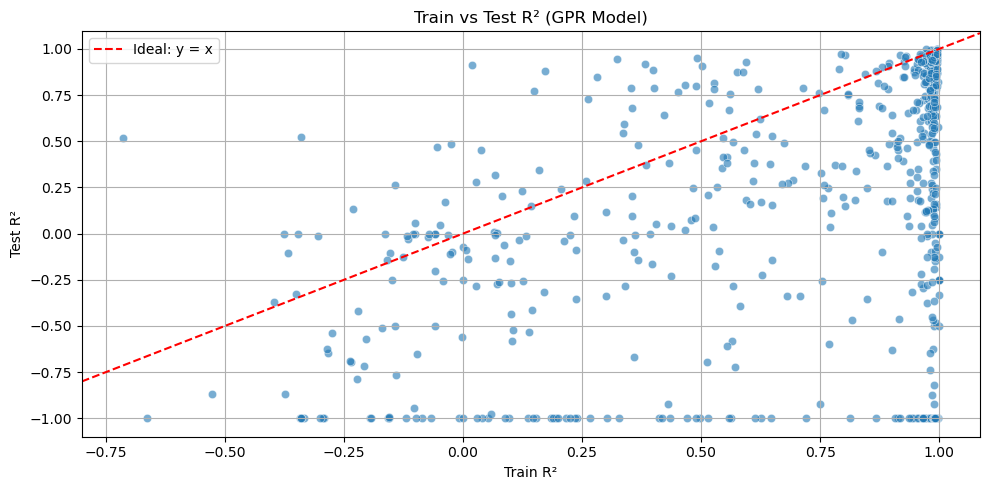

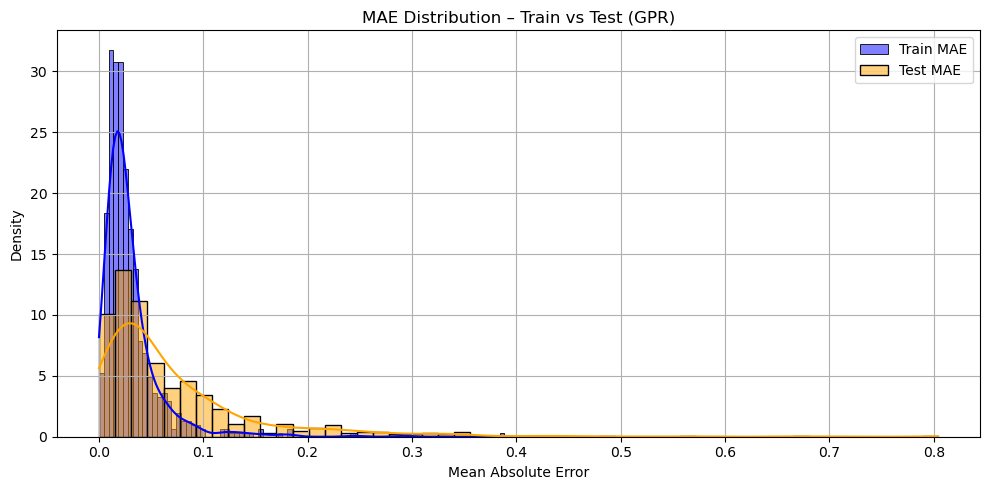

C:\Users\adire\AppData\Local\Temp\ipykernel_23136\2652593429.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\adire\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


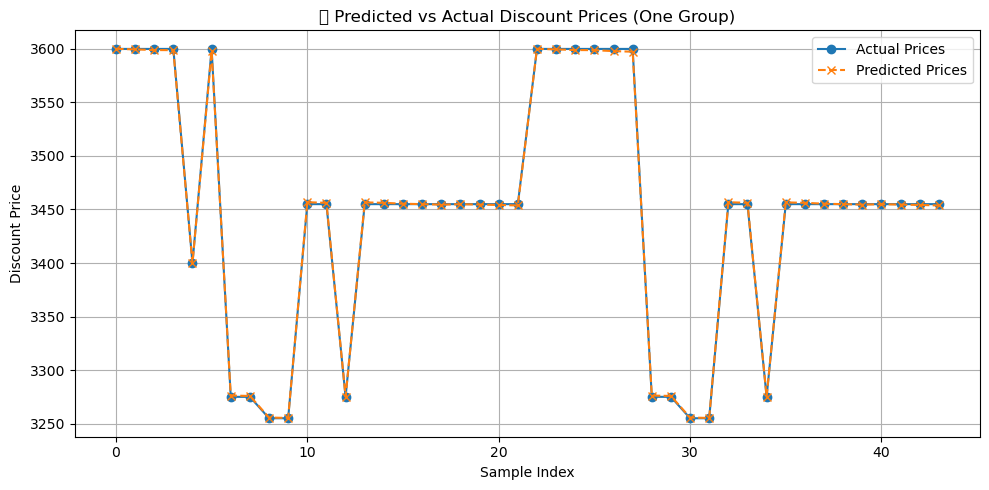

In [93]:
# Cell 12: Analyze GPR Results – Summary & Visual Comparison

# --- Ensure results dataframe exists ---
assert 'gpr_results_df' in globals(), "❌ gpr_results_df not found. Please run the GPR modeling cell first."

# --- Summary Statistics ---
avg_train_r2 = gpr_results_df['Train R²'].mean()
avg_test_r2 = gpr_results_df['Test R²'].mean()
avg_train_mae = gpr_results_df['Train MAE'].mean()
avg_test_mae = gpr_results_df['Test MAE'].mean()

print("📊 GPR Model Performance Summary:")
print(f"🔹 Average Train R²: {avg_train_r2:.4f}")
print(f"🔹 Average Test  R²: {avg_test_r2:.4f}")
print(f"🔹 Average Train MAE: {avg_train_mae:.4f}")
print(f"🔹 Average Test  MAE: {avg_test_mae:.4f}")

# --- Split results by test R² ---
good_models = gpr_results_df[gpr_results_df['Test R²'] >= 0].copy()
bad_models = gpr_results_df[gpr_results_df['Test R²'] < 0].copy()

print(f"\n✅ Good models: {len(good_models)}")
print(f"❌ Bad models : {len(bad_models)}")

# --- Summary Table (Good vs Bad) ---
numeric_cols = ['Train R²', 'Test R²', 'Train MAE', 'Test MAE', 'Train Size', 'Test Size', 'Samples Used']
good_stats = good_models[numeric_cols].describe().T
bad_stats = bad_models[numeric_cols].describe().T

comparison = pd.concat([good_stats[['mean', 'std']], bad_stats[['mean', 'std']]], axis=1)
comparison.columns = ['Good Mean', 'Good Std', 'Bad Mean', 'Bad Std']

print("\n📈 Statistical Comparison Between Good and Bad GPR Models:")
display(comparison)

# --- R² Train vs Test Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gpr_results_df, x='Train R²', y='Test R²', alpha=0.6)
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal: y = x')
plt.title('Train vs Test R² (GPR Model)')
plt.xlabel('Train R²')
plt.ylabel('Test R²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- MAE Distributions ---
plt.figure(figsize=(10, 5))
sns.histplot(gpr_results_df['Train MAE'], color='blue', label='Train MAE', kde=True, stat='density')
sns.histplot(gpr_results_df['Test MAE'], color='orange', label='Test MAE', kde=True, stat='density')
plt.title('MAE Distribution – Train vs Test (GPR)')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visual Example: Predicted vs Actual on a Single Group (from Cell 9) ---
if 'result' in globals() and 'original_subset' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(original_subset['Discount Price'].values, label='Actual Prices', marker='o')
    plt.plot(result['final_predictions'], label='Predicted Prices', linestyle='--', marker='x')
    plt.title('📈 Predicted vs Actual Discount Prices (One Group)')
    plt.xlabel('Sample Index')
    plt.ylabel('Discount Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipping visual plot for one group – run Cell 9 first.")


### 4.9 - Compression

#### Save Result

In [ ]:
# Cell 15: Export Results & Summary

# Export results to CSV
results_df.to_csv("Output/base_model_results.csv", index=False)
gpr_results_df.to_csv("Output/gpr_model_results.csv", index=False)

# Summary print
print("✅ Export complete. Results saved to 'Output' folder.\n")

print("📊 Final Summary:")
print(f"- Base Model: {results_df.shape[0]} models | Avg R² = {results_df['R2 Score'].mean():.4f}")
print(f"- GPR Model : {gpr_results_df.shape[0]} models | Avg R² = {gpr_results_df['R2 Score'].mean():.4f}")

# Optional: show head of each file
print("\n📄 Base Model Preview:")
display(results_df.head())

print("\n📄 GPR Model Preview:")
display(gpr_results_df.head())

OSError: Cannot save file into a non-existent directory: 'Output'